In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import fftpack
import datetime
from sklearn import mixture
import warnings
warnings.filterwarnings('ignore')

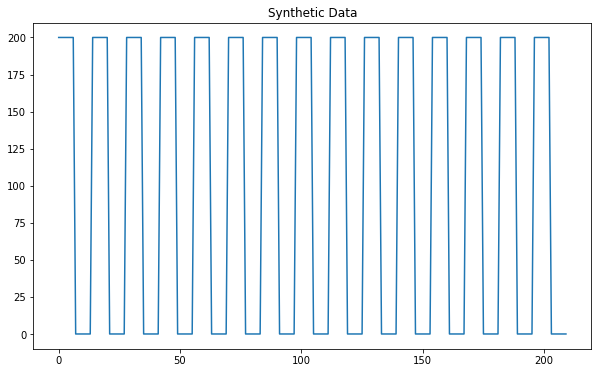

In [2]:
# SIGNAL 1
x1 = np.arange(0, 210)
y1 = np.zeros(210)
value = 200
y1[0] = 200
for i in range (1, 210):
    if i%7 != 0:
        y1[i] = value
    else:
        value = abs(value-200)
        y1[i] = value
plt.figure(figsize=(10,6))
plt.plot(x1, y1)
plt.title("Synthetic Data")
plt.show()

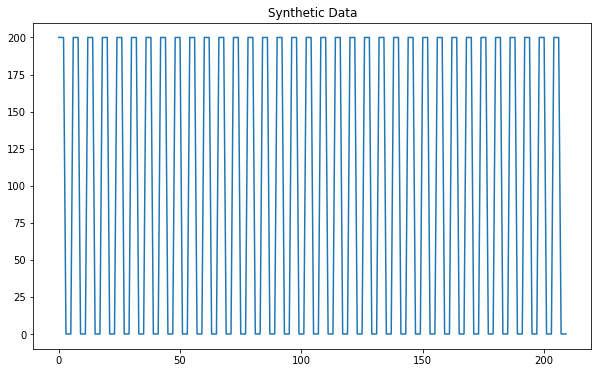

In [3]:
# SIGNAL 2
x2 = np.arange(0, 210)
y2 = np.zeros(210)
value = 200
y2[0] = 200
for i in range(1,210):
    if i%3 !=0:
        y2[i] = value
    else:
        value = abs(value-200)
        y2[i] = value
plt.figure(figsize=(10,6))
plt.plot(x2, y2)
plt.title("Synthetic Data")
plt.show()

In [4]:
signal_1 = pd.DataFrame(zip(x1,y1),columns=['Time','Value'])
signal_2 = pd.DataFrame(zip(x2,y2),columns=['Time','Value'])
signal_1.describe()

,Time,Value
count,210.000000,210.000000
mean,104.500000,100.000000
std,60.765944,100.238949
min,0.000000,0.000000
25%,52.250000,0.000000
50%,104.500000,100.000000
75%,156.750000,200.000000
max,209.000000,200.000000


In [5]:
signal_2.describe()

,Time,Value
count,210.000000,210.000000
mean,104.500000,100.000000
std,60.765944,100.238949
min,0.000000,0.000000
25%,52.250000,0.000000
50%,104.500000,100.000000
75%,156.750000,200.000000
max,209.000000,200.000000


In [6]:
def freq(df):
    N = df.shape[0]
    y = np.array(df['Value'])
    f = fftpack.fftfreq(len(y))
    yf = fftpack.fft(y)
    freq_ampli = pd.DataFrame(zip(np.abs(f[:N//2+1]),np.abs(yf[:N//2+1])),columns=['Freq','Ampli'])
    return freq_ampli 

In [7]:
freq_ampli1 = freq(signal_1)
freq_ampli2 = freq(signal_2)

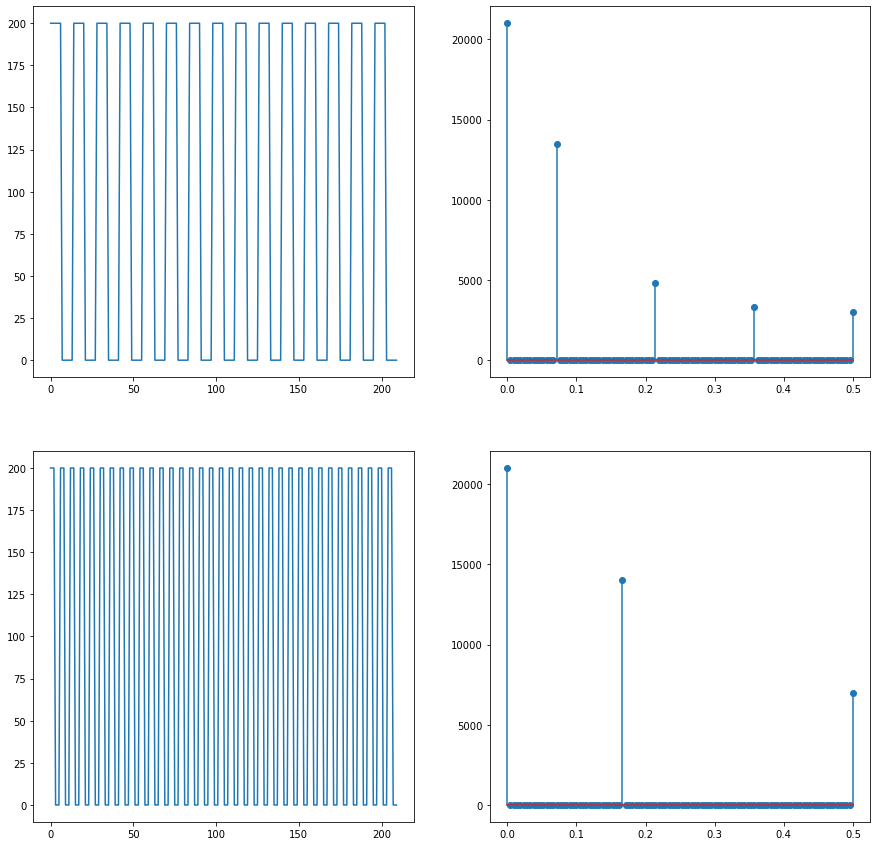

In [8]:
fig, axs = plt.subplots(2, 2,figsize=(15,15))
axs[0,0].plot(signal_1['Time'], signal_1['Value'])
axs[0,1].stem(freq_ampli1['Freq'], freq_ampli1['Ampli'])
axs[1,0].plot(signal_2['Time'], signal_2['Value'])
axs[1,1].stem(freq_ampli2['Freq'], freq_ampli2['Ampli'])
plt.show()

In [9]:
freq_ampli_log1 = pd.DataFrame(zip(freq_ampli1['Freq'], np.log(freq_ampli1['Ampli'])),columns=['Freq','Ampli'])
freq_ampli_log2 = pd.DataFrame(zip(freq_ampli2['Freq'], np.log(freq_ampli2['Ampli'])),columns=['Freq','Ampli'])

In [10]:
def GMM_fit(df):
    dfx = df
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 7)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(dfx)
            bic.append(gmm.bic(dfx))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm

In [11]:
best_gmm00 = GMM_fit(signal_1)
best_gmm01 = GMM_fit(np.array(signal_1['Value']).reshape(-1,1))
best_gmm02 = GMM_fit(freq_ampli1)#.iloc[1:,:])
#best_gmm03 = GMM_fit(freq_ampli_log1)
best_gmm10 = GMM_fit(signal_2)
best_gmm11 = GMM_fit(np.array(signal_2['Value']).reshape(-1,1))
best_gmm12 = GMM_fit(freq_ampli2)#.iloc[1:,:])
#best_gmm13 = GMM_fit(freq_ampli_log2)

## Time Series

In [12]:
print(best_gmm00)
print(best_gmm10)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)


In [13]:
print(best_gmm00.weights_)
print()
print(best_gmm10.weights_)

[0.5 0.5]

[0.5 0.5]


In [14]:
print(best_gmm00.means_)
print()
print(best_gmm10.means_)

[[108.   0.]
 [101. 200.]]

[[103. 200.]
 [106.   0.]]


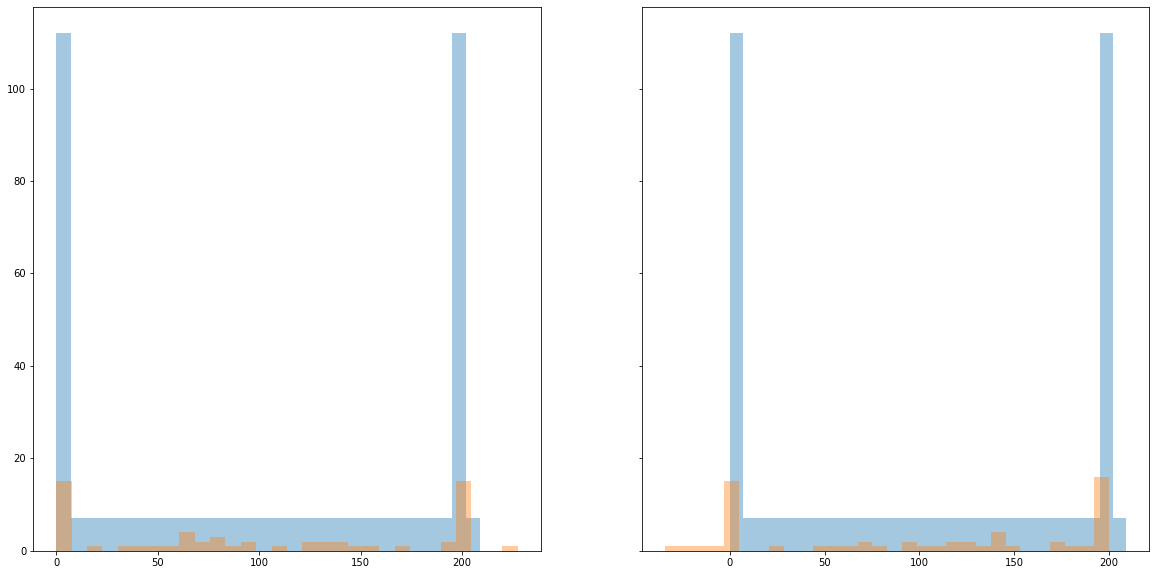

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10),sharey=True)
sns.distplot(signal_1,kde=False,bins=30,ax=ax1)
z1,_ = best_gmm00.sample(30)
sns.distplot(z1,kde=False,bins=30,ax=ax1)

sns.distplot(signal_2,kde=False,bins=30,ax=ax2)
z2,_ = best_gmm10.sample(30)
sns.distplot(z2,kde=False,bins=30,ax=ax2)
plt.show()

In [16]:
print(best_gmm00.score(signal_1))
print(best_gmm10.score(signal_2))

-0.22624234726068124
-0.22760561266943027


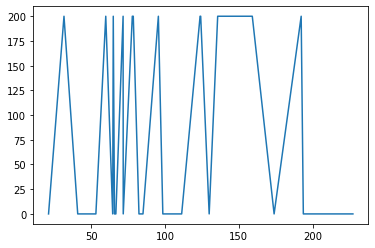

In [17]:
sns.lineplot(z1[:,0],z1[:,1])

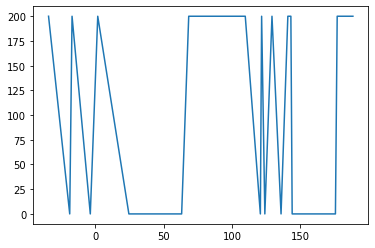

In [18]:
sns.lineplot(z2[:,0],z2[:,1])

## Histogram of TS

In [19]:
print(best_gmm01)
print(best_gmm11)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)


In [20]:
print(best_gmm01.weights_)
print()
print(best_gmm11.weights_)

[0.5 0.5]

[0.5 0.5]


In [21]:
print(best_gmm01.means_)
print()
print(best_gmm11.means_)

[[  0.]
 [200.]]

[[200.]
 [  0.]]


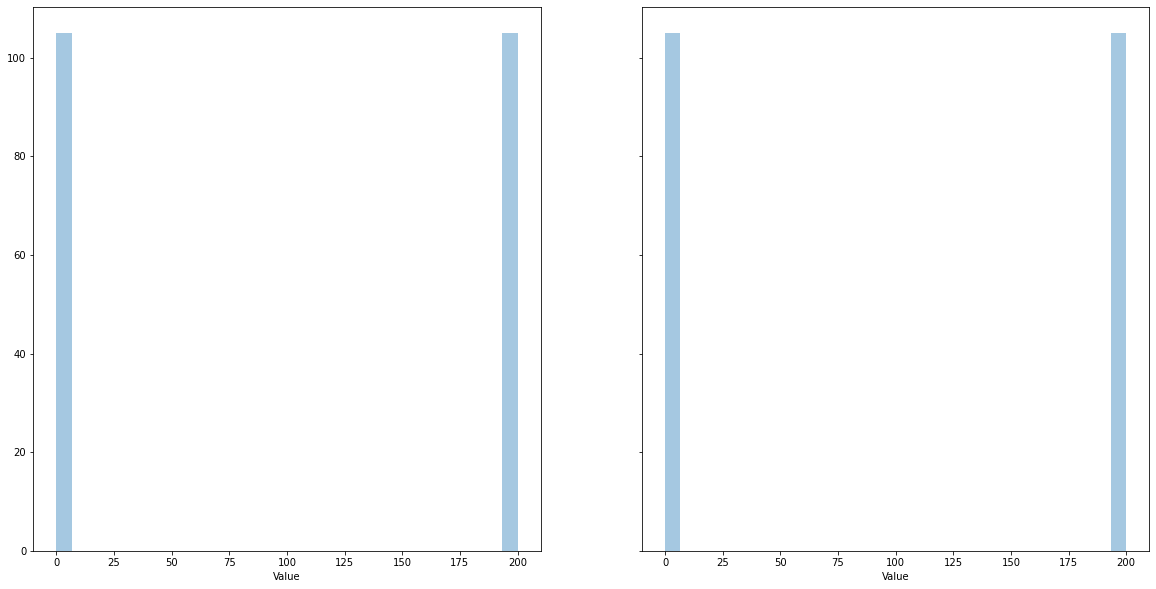

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10),sharey=True)
sns.distplot(signal_1['Value'],kde=False,bins=30,ax=ax1)
z1,_ = best_gmm01.sample(30)
#sns.distplot(z1,kde=False,bins=30,ax=ax1)

sns.distplot(signal_2['Value'],kde=False,bins=30,ax=ax2)
z2,_ = best_gmm11.sample(30)
#sns.distplot(z2,kde=False,bins=30,ax=ax2)
plt.show()

In [23]:
print(best_gmm01.score(np.array(signal_1['Value']).reshape(-1,1)))
print(best_gmm11.score(np.array(signal_2['Value']).reshape(-1,1)))

5.29566956521752
5.29566956521752


## Frequency (FFT)

In [24]:
print(best_gmm02)
print(best_gmm12)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)


In [25]:
print(best_gmm02.weights_)
print()
print(best_gmm12.weights_)

[0.95283019 0.00943396 0.00943396 0.00943396 0.00943396 0.00943396]

[0.97169811 0.00943396 0.00943396 0.00943396]


In [26]:
print(best_gmm02.means_)
print()
print(best_gmm12.means_)

[[2.51060820e-01 1.80494316e-13]
 [0.00000000e+00 2.10000000e+04]
 [7.14285714e-02 1.34818776e+04]
 [5.00000000e-01 3.00000000e+03]
 [2.14285714e-01 4.81162641e+03]
 [3.57142857e-01 3.32974879e+03]]

[[2.50809061e-01 1.42276868e-14]
 [0.00000000e+00 2.10000000e+04]
 [1.66666667e-01 1.40000000e+04]
 [5.00000000e-01 7.00000000e+03]]


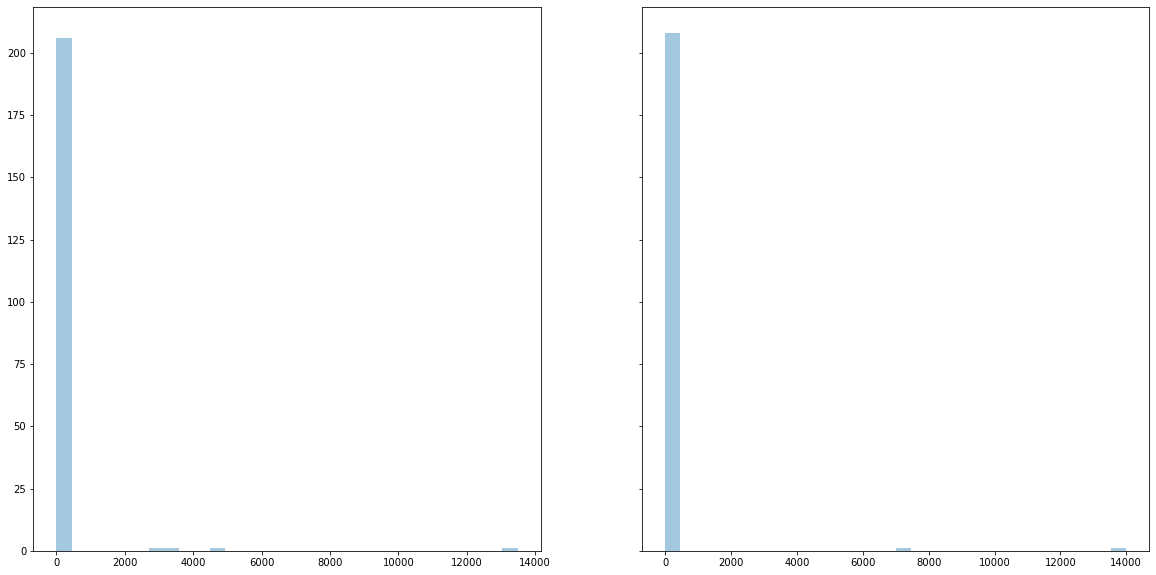

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10),sharey=True)
sns.distplot(freq_ampli1.iloc[1:,:],kde=False,bins=30,ax=ax1)
z1,_ = best_gmm02.sample(210)
#sns.distplot(z1,kde=False,bins=30,ax=ax1)

sns.distplot(freq_ampli2.iloc[1:,:],kde=False,bins=30,ax=ax2)
z2,_ = best_gmm12.sample(210)
#sns.distplot(z2,kde=False,bins=30,ax=ax2)
plt.show()

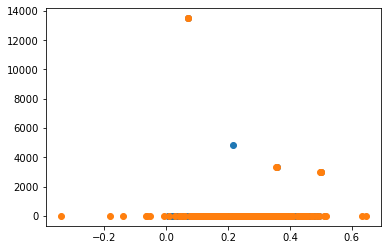

In [28]:
plt.scatter(freq_ampli1.iloc[1:,0],freq_ampli1.iloc[1:,1])
plt.scatter(z1[:,0],z1[:,1])

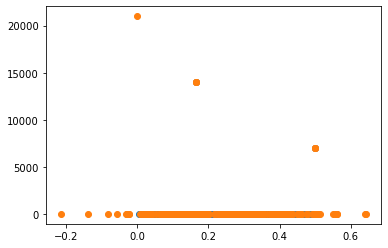

In [29]:
plt.scatter(freq_ampli2.iloc[1:,0],freq_ampli2.iloc[1:,1])
plt.scatter(z2[:,0],z2[:,1])

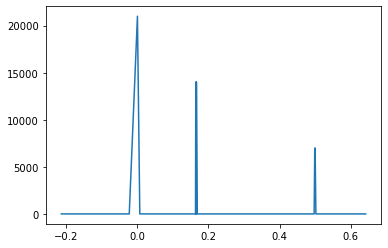

In [30]:
sns.lineplot(z2[:,0],z2[:,1])

In [31]:
print(best_gmm02.score(freq_ampli1.iloc[1:,:]))
print(best_gmm12.score(freq_ampli2.iloc[1:,:]))

6.493085092682197
6.496911567280533


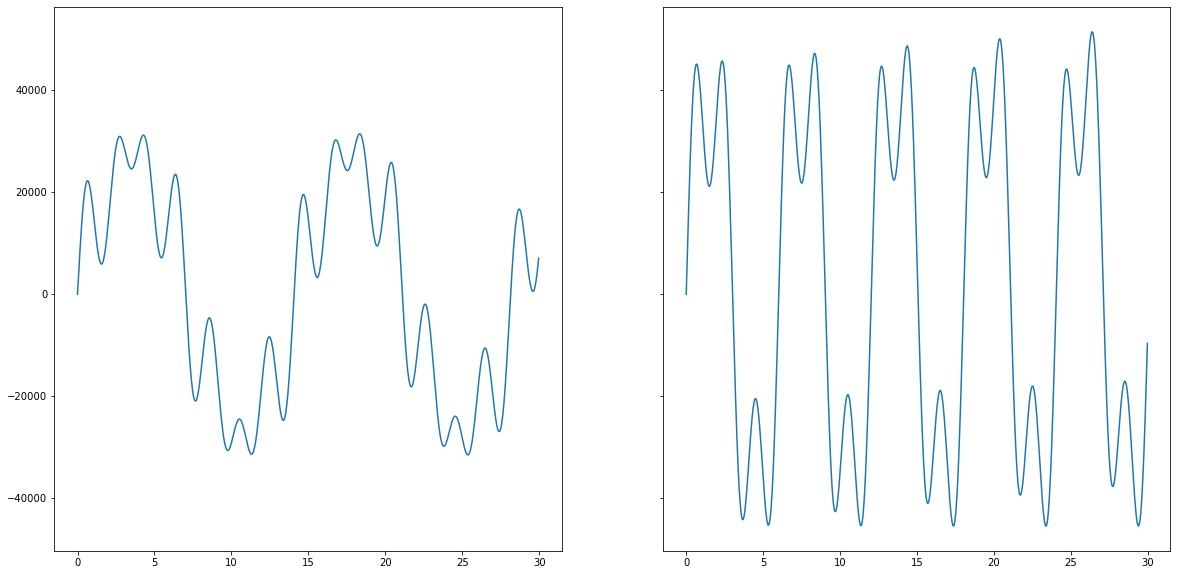

In [32]:
Fs = 30
t = np.arange(0,30,1/Fs)
a=0
y=0
for [i,j] in z1:
    if i > 0:
        y += j*np.sin(2 * np.pi * (i) * t)
for [i,j] in z2:
    if i > 0:
        a += j*np.sin(2 * np.pi * (i) * t)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10),sharey=True)
ax1.plot(t,y)
ax2.plot(t,a)

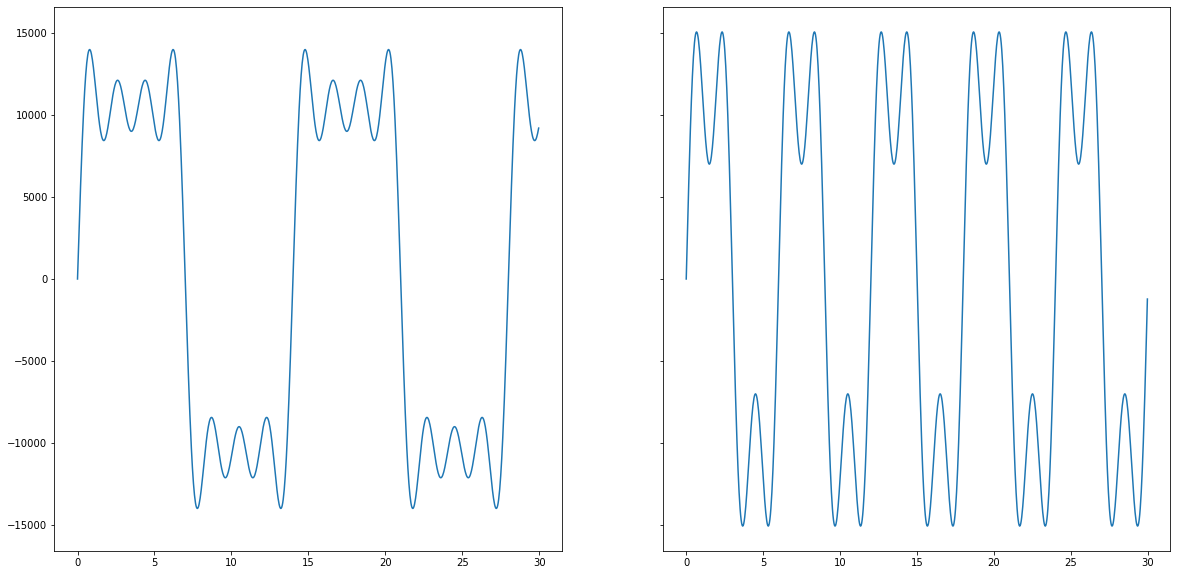

In [33]:
Fs = 30
t = np.arange(0,30,1/Fs)
y = 0
a = 0
for [i,j] in np.array(freq_ampli1):
    y += j*np.sin(2 * np.pi * (i) * t)
for [i,j] in np.array(freq_ampli2):
    a += j*np.sin(2 * np.pi * (i) * t)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10),sharey=True)
ax1.plot(t,y)
ax2.plot(t,a)

## IFT

In [34]:
y = np.array(signal_1['Value'])
f = fftpack.fftfreq(len(y))
yf = fftpack.fft(y)

In [35]:
yf

array([ 2.10000000e+04-0.00000000e+00j,  1.20827625e-14+3.99315176e-13j,
       -1.69658409e-13+1.75301260e-13j,  1.02560813e-13+1.30387773e-14j,
        1.68038457e-14-1.38076938e-13j,  1.40521312e-13-4.96018893e-14j,
        2.42343217e-13-2.04223332e-13j,  0.00000000e+00+0.00000000e+00j,
       -3.44845213e-15+3.27168518e-13j,  2.59164445e-14-3.34859928e-14j,
        2.33336352e-14+5.05078722e-15j, -4.41547215e-14-9.14869101e-15j,
       -6.43262584e-14+1.39325236e-14j,  4.96257148e-13-2.68877972e-13j,
        8.89373350e-14-9.87749173e-14j,  3.00000000e+03-1.31438588e+04j,
       -7.73013900e-14-8.48857866e-14j, -2.85649803e-13-3.52811180e-13j,
        1.18353761e-13+5.11910368e-14j,  8.88573374e-14-3.33915961e-14j,
       -7.61660496e-13+8.15232712e-13j,  2.84217094e-14-8.74730272e-14j,
       -6.60762742e-13-3.22848742e-13j, -3.50392545e-14+2.76489865e-14j,
       -1.76653618e-13-1.88193184e-13j,  2.44003386e-13-7.13150261e-14j,
        1.16268000e-13-7.83158295e-14j, -4.99831198

## True IFT

In [36]:
from scipy import fft
yi = fft.ifft(yf)

In [37]:
yr = fft.ifft(yf.real)

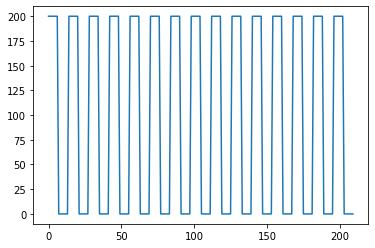

In [38]:
plt.plot(x1,yi.real)

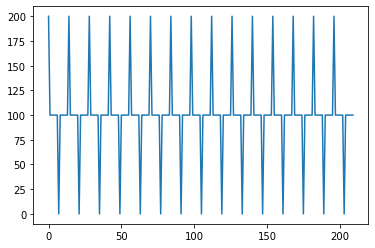

In [39]:
plt.plot(x1,yr)

## Sample IFT

In [40]:
fas = pd.DataFrame(zip(z1[:,0],z1[:,1]),columns = ['Freq','Ampli'])
fas

,Freq,Ampli
0,0.222330,-0.002398
1,0.269382,-0.002089
2,0.633788,0.001434
3,0.326341,0.001525
4,0.230508,-0.000032
...,...,...
205,0.499244,3000.000771
206,0.498454,2999.999234
207,0.499074,3000.001183
208,0.358460,3329.747462


In [41]:
new_df = fas[fas.Freq>=0]

In [42]:
new_df = new_df.sort_values(by=['Freq'],ascending=True)
new_df.head(20)

,Freq,Ampli
34,0.008714,0.000549
128,0.028750,-0.000679
45,0.042135,0.000293
181,0.046419,-0.000664
57,0.058360,0.000349
78,0.061092,-0.000715
204,0.069573,13481.881233
203,0.070670,13481.877047
129,0.075745,0.000539
132,0.077744,-0.000832


In [43]:
new_df1 = new_df[new_df.Ampli > 1]
new_df1

,Freq,Ampli
204,0.069573,13481.881233
203,0.070670,13481.877047
209,0.355781,3329.749200
208,0.358460,3329.747462
206,0.498454,2999.999234
207,0.499074,3000.001183
205,0.499244,3000.000771


In [44]:
new_df1.Freq = round(new_df1.Freq,3)
new_df1

,Freq,Ampli
204,0.070,13481.881233
203,0.071,13481.877047
209,0.356,3329.749200
208,0.358,3329.747462
206,0.498,2999.999234
207,0.499,3000.001183
205,0.499,3000.000771


In [45]:
di = dict(zip(new_df1.Freq,new_df1.Ampli))
di

{0.07: 13481.881233276668,
 0.071: 13481.877046596763,
 0.356: 3329.7491996593467,
 0.358: 3329.7474622196114,
 0.498: 2999.999234187298,
 0.499: 3000.000770865689}

In [46]:
d = dict(zip(f,np.zeros(len(f))))
d

{0.0: 0.0,
 0.004761904761904762: 0.0,
 0.009523809523809525: 0.0,
 0.014285714285714287: 0.0,
 0.01904761904761905: 0.0,
 0.02380952380952381: 0.0,
 0.028571428571428574: 0.0,
 0.03333333333333334: 0.0,
 0.0380952380952381: 0.0,
 0.04285714285714286: 0.0,
 0.04761904761904762: 0.0,
 0.05238095238095239: 0.0,
 0.05714285714285715: 0.0,
 0.06190476190476191: 0.0,
 0.06666666666666668: 0.0,
 0.07142857142857144: 0.0,
 0.0761904761904762: 0.0,
 0.08095238095238096: 0.0,
 0.08571428571428572: 0.0,
 0.09047619047619049: 0.0,
 0.09523809523809525: 0.0,
 0.1: 0.0,
 0.10476190476190478: 0.0,
 0.10952380952380954: 0.0,
 0.1142857142857143: 0.0,
 0.11904761904761905: 0.0,
 0.12380952380952381: 0.0,
 0.1285714285714286: 0.0,
 0.13333333333333336: 0.0,
 0.1380952380952381: 0.0,
 0.14285714285714288: 0.0,
 0.14761904761904762: 0.0,
 0.1523809523809524: 0.0,
 0.15714285714285717: 0.0,
 0.1619047619047619: 0.0,
 0.16666666666666669: 0.0,
 0.17142857142857143: 0.0,
 0.1761904761904762: 0.0,
 0.1809523

In [47]:
d[0.0] = 21000.000498727768
d[0.07142857142857144] = 13481.87783694458#3000.00075291306
d[0.2142857142857143] = 4811.6274849831525#3000.00075291306#
d[0.35714285714285715] = 3329.748167140082#3000.00075291306#
d[-0.5] = 3000.00075291306
d[-0.07142857142857144] = 13481.87783694458#3000.00075291306#
d[-0.2142857142857143] = 4811.6274849831525#3000.00075291306#
d[-0.35714285714285715] = 3329.748167140082#3000.00075291306#
d

{0.0: 21000.000498727768,
 0.004761904761904762: 0.0,
 0.009523809523809525: 0.0,
 0.014285714285714287: 0.0,
 0.01904761904761905: 0.0,
 0.02380952380952381: 0.0,
 0.028571428571428574: 0.0,
 0.03333333333333334: 0.0,
 0.0380952380952381: 0.0,
 0.04285714285714286: 0.0,
 0.04761904761904762: 0.0,
 0.05238095238095239: 0.0,
 0.05714285714285715: 0.0,
 0.06190476190476191: 0.0,
 0.06666666666666668: 0.0,
 0.07142857142857144: 13481.87783694458,
 0.0761904761904762: 0.0,
 0.08095238095238096: 0.0,
 0.08571428571428572: 0.0,
 0.09047619047619049: 0.0,
 0.09523809523809525: 0.0,
 0.1: 0.0,
 0.10476190476190478: 0.0,
 0.10952380952380954: 0.0,
 0.1142857142857143: 0.0,
 0.11904761904761905: 0.0,
 0.12380952380952381: 0.0,
 0.1285714285714286: 0.0,
 0.13333333333333336: 0.0,
 0.1380952380952381: 0.0,
 0.14285714285714288: 0.0,
 0.14761904761904762: 0.0,
 0.1523809523809524: 0.0,
 0.15714285714285717: 0.0,
 0.1619047619047619: 0.0,
 0.16666666666666669: 0.0,
 0.17142857142857143: 0.0,
 0.1761

In [48]:
value = list(d.values())
#value = [i * 105 for i in value]

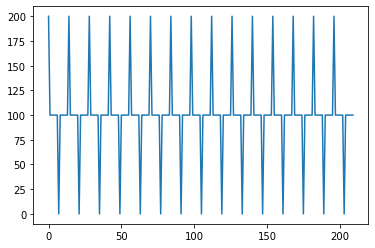

In [49]:
plt.plot(x1,yr)

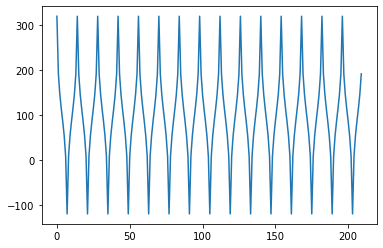

In [50]:
yrs = fft.ifft(value)
plt.plot(x1,yrs)

In [51]:
xq = pd.DataFrame(yf.real)
xq = xq[xq[0] > 1]
xq

,0
0,21000.0
15,3000.0
45,3000.0
75,3000.0
105,3000.0
135,3000.0
165,3000.0
195,3000.0


In [52]:
new_x = list(freq_ampli1.Ampli)+list(freq_ampli1.Ampli)[-2:0:-1]

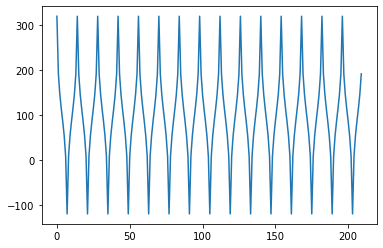

In [56]:
yrs = fft.ifft(new_x)
plt.plot(x1,yrs)